In [1]:
!!pip install tensorflow

['Requirement already satisfied: tensorflow in /usr/local/lib/python3.12/dist-packages (2.19.0)',
 'Requirement already satisfied: absl-py>=1.0.0 in /usr/local/lib/python3.12/dist-packages (from tensorflow) (1.4.0)',
 'Requirement already satisfied: astunparse>=1.6.0 in /usr/local/lib/python3.12/dist-packages (from tensorflow) (1.6.3)',
 'Requirement already satisfied: flatbuffers>=24.3.25 in /usr/local/lib/python3.12/dist-packages (from tensorflow) (25.9.23)',
 'Requirement already satisfied: gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1 in /usr/local/lib/python3.12/dist-packages (from tensorflow) (0.6.0)',
 'Requirement already satisfied: google-pasta>=0.1.1 in /usr/local/lib/python3.12/dist-packages (from tensorflow) (0.2.0)',
 'Requirement already satisfied: libclang>=13.0.0 in /usr/local/lib/python3.12/dist-packages (from tensorflow) (18.1.1)',
 'Requirement already satisfied: opt-einsum>=2.3.2 in /usr/local/lib/python3.12/dist-packages (from tensorflow) (3.4.0)',
 'Requirement already sati

In [2]:
import pandas as pd
import os
import shutil
from tqdm.notebook import tqdm as tq
import pathlib
import gdown
import zipfile
import numpy as np
import random

In [3]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
from keras.utils import to_categorical
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Load Data

In [7]:
# ID file Google Drive
file_id = '1m7xfkbX9deDddPIHgitsCZzIPba2DT1k'
zip_name = 'Dataset-Final.zip'

# Download file dari Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', zip_name, quiet=False)

# Buat folder untuk ekstrak
extract_path = 'Dataset-Final'
os.makedirs(extract_path, exist_ok=True)

# Ekstrak ZIP
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Lihat isi folder
os.listdir(extract_path)


Downloading...
From (original): https://drive.google.com/uc?id=1m7xfkbX9deDddPIHgitsCZzIPba2DT1k
From (redirected): https://drive.google.com/uc?id=1m7xfkbX9deDddPIHgitsCZzIPba2DT1k&confirm=t&uuid=077ddb63-cb53-422f-ad17-f647ded120b3
To: /content/Dataset-Final.zip
100%|██████████| 155M/155M [00:00<00:00, 182MB/s]


['train', 'val', 'test']

# Modelling

In [8]:
# Define training, validation, and test directories
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR = "Dataset-Final/val/"
TEST_DIR = "Dataset-Final/test/"


In [9]:
# Augmentasi data training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.0,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=False,
    fill_mode='nearest'
)

# Preprocessing data validation
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Preprocessing data test
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Membuat generator data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

Found 4918 images belonging to 4 classes.
Found 1051 images belonging to 4 classes.
Found 1054 images belonging to 4 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
class AccuracyThresholdStopping(Callback):
    def __init__(self, target_accuracy=0.96):
        super().__init__()
        self.target_accuracy = target_accuracy
        self.last_train_accuracy = 0
        self.last_val_accuracy = 0

    def on_epoch_end(self, epoch, logs=None):
        self.last_val_accuracy = logs.get('val_accuracy')
        self.last_train_accuracy = logs.get('accuracy')

        if self.last_val_accuracy is not None and self.last_train_accuracy is not None:
            if self.last_val_accuracy >= self.target_accuracy and self.last_train_accuracy >= self.target_accuracy:
                print(f"\nTraining dan Validation accuracy sudah mencapai {self.target_accuracy*100:.1f}%, menghentikan training.")
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        print(f"\nAkurasi terakhir Training: {self.last_train_accuracy*100:.2f}%")
        print(f"Akurasi terakhir Validation: {self.last_val_accuracy*100:.2f}%")

# EarlyStopping berdasarkan akurasi, kalau tidak meningkat
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, min_delta=0.01)

# Reduce learning rate jika akurasi validasi tidak meningkat
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.0001)

# Custom Callback untuk target 95%
accuracy_stop = AccuracyThresholdStopping(target_accuracy=0.96)

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
steps_per_epoch = math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps = math.ceil(validation_generator.samples / validation_generator.batch_size)

# Fit model dengan callbacks yang sudah disesuaikan
hist = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping,accuracy_stop,reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6181 - loss: 0.9491 - val_accuracy: 0.8563 - val_loss: 0.3318 - learning_rate: 0.0010
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8360 - loss: 0.4100 - val_accuracy: 0.8820 - val_loss: 0.3049 - learning_rate: 0.0010
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8652 - loss: 0.3551 - val_accuracy: 0.9163 - val_loss: 0.2241 - learning_rate: 0.0010
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8961 - loss: 0.2865 - val_accuracy: 0.9106 - val_loss: 0.2374 - learning_rate: 0.0010
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9026 - loss: 0.2616 - val_accuracy: 0.9363 - val_loss: 0.1839 - learning_rate: 0.0010
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9060 - loss: 0.2450 - val_accuracy: 0.9172 - val_loss: 0.2162 - learning_rate: 0.0010
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9072 - loss: 0.2387 - val_accuracy:

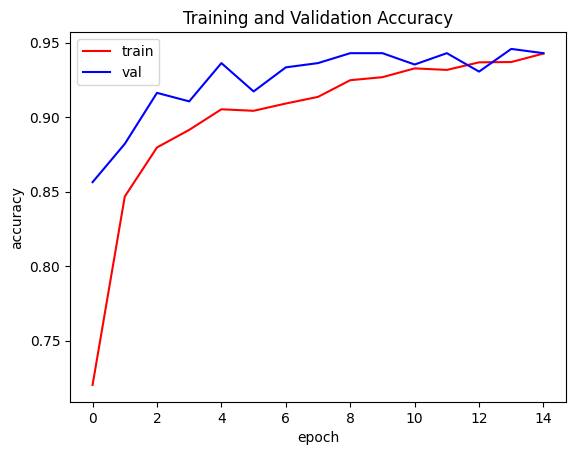

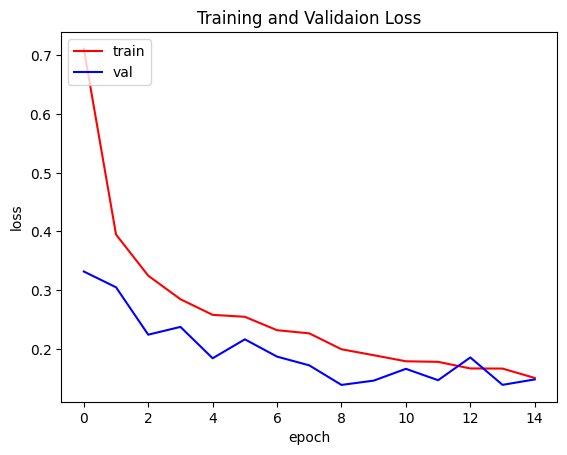

In [14]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [15]:
# Evaluasi model menggunakan data test
loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 856ms/step - accuracy: 0.9215 - loss: 0.2041
Loss: 0.1679
Accuracy: 0.9393


In [16]:
# Prediksi probabilitas pada data test
pred_probs = model.predict(test_generator, verbose=1)
# Ambil kelas prediksi berdasarkan probabilitas tertinggi
y_pred = np.argmax(pred_probs, axis=1)
# Ambil label asli
y_true = test_generator.classes

# Ambil label kelas dari test_generator
class_labels = list(test_generator.class_indices.keys())

# Tampilkan Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Tampilkan classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 778ms/step
Confusion Matrix:
[[217  25   0   1]
 [ 10 223   9   5]
 [  0   3 297   0]
 [  2   9   0 253]]

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.95      0.89      0.92       243
  Meningioma       0.86      0.90      0.88       247
    No_tumor       0.97      0.99      0.98       300
   Pituitary       0.98      0.96      0.97       264

    accuracy                           0.94      1054
   macro avg       0.94      0.94      0.94      1054
weighted avg       0.94      0.94      0.94      1054



## Konversi Model

### h5

In [17]:
model.save("model.h5")

In [21]:
# 3. Buat file ZIP yang berisi file model.h5
with zipfile.ZipFile("model_h5.zip", 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("model.h5")

## Inference Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[1]
Gambar dipilih : Dataset-Final/test/No_tumor/Tr-no_0711.jpg
Hasil Prediksi : No_tumor


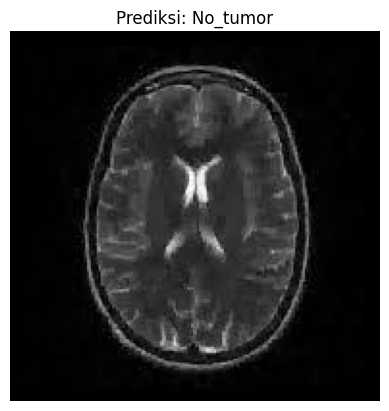

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[2]
Gambar dipilih : Dataset-Final/test/Glioma/Tr-gl_0372.jpg
Hasil Prediksi : Glioma


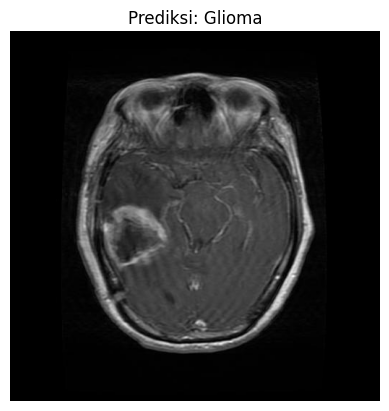

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[3]
Gambar dipilih : Dataset-Final/test/Glioma/Tr-gl_1031.jpg
Hasil Prediksi : Glioma


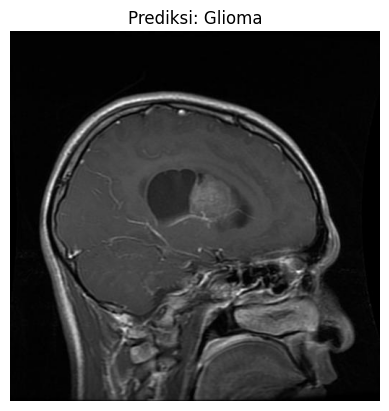

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[4]
Gambar dipilih : Dataset-Final/test/Glioma/Tr-gl_1007.jpg
Hasil Prediksi : Glioma


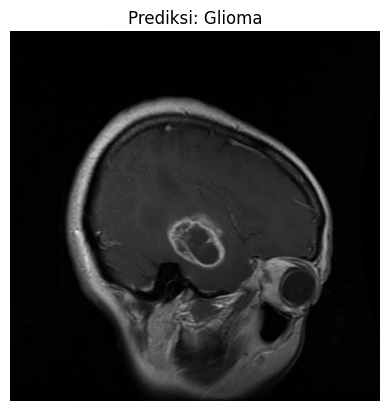

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[5]
Gambar dipilih : Dataset-Final/test/Pituitary/Tr-pi_0223.jpg
Hasil Prediksi : Pituitary


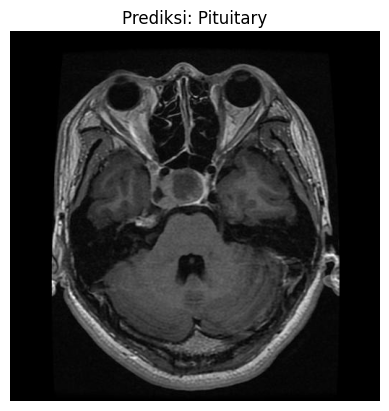

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[6]
Gambar dipilih : Dataset-Final/test/No_tumor/Tr-no_0564.jpg
Hasil Prediksi : No_tumor


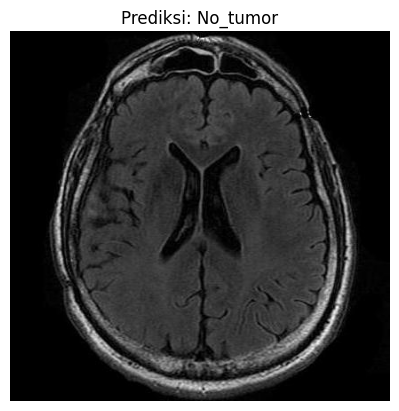

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[7]
Gambar dipilih : Dataset-Final/test/No_tumor/Tr-no_0066.jpg
Hasil Prediksi : No_tumor


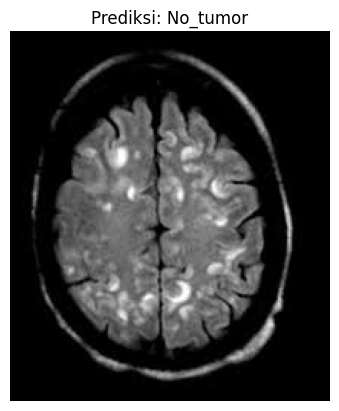

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[8]
Gambar dipilih : Dataset-Final/test/Glioma/Tr-gl_0743.jpg
Hasil Prediksi : Glioma


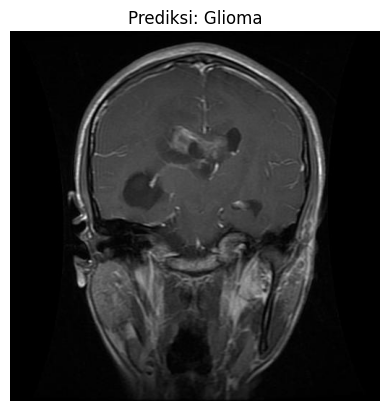

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[9]
Gambar dipilih : Dataset-Final/test/Meningioma/Te-me_0054.jpg
Hasil Prediksi : Meningioma


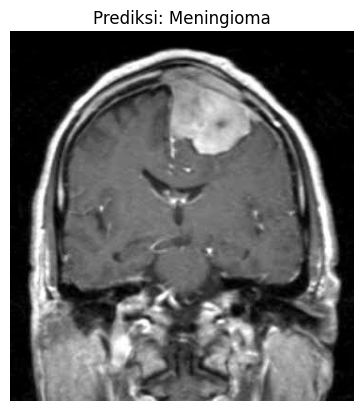

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[10]
Gambar dipilih : Dataset-Final/test/No_tumor/Tr-no_0550.jpg
Hasil Prediksi : No_tumor


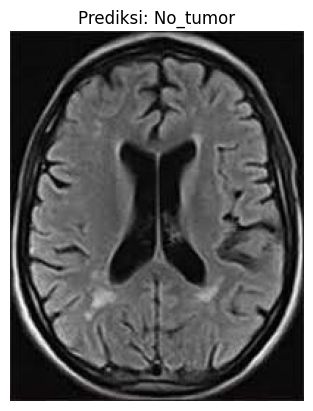

In [18]:
# Path folder data dan model
base_dir = 'Dataset-Final/test/'
model_path = 'model.h5'

# Load model HDF5
model = load_model(model_path)

# List semua kelas
kelas_list = os.listdir(base_dir)
kelas_list.sort()

# Jumlah gambar yang akan dicek
jumlah_gambar = 10

for i in range(jumlah_gambar):
    # --- Ambil gambar random dari folder yang tidak kosong ---
    while True:
        kelas_random = random.choice(kelas_list)
        kelas_path = os.path.join(base_dir, kelas_random)
        gambar_list = os.listdir(kelas_path)
        if gambar_list:  # jika tidak kosong
            gambar_random = random.choice(gambar_list)
            gambar_path = os.path.join(kelas_path, gambar_random)
            break

    # --- Load gambar ---
    img = load_img(gambar_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # --- Prediksi ---
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction[0])
    predicted_class_name = kelas_list[predicted_index]

    # --- Print hasil ---
    print("="*50)
    print(f"[{i+1}]")
    print(f"Gambar dipilih : {gambar_path}")
    print(f"Hasil Prediksi : {predicted_class_name}")

        # --- Tampilkan gambar ---
    plt.imshow(load_img(gambar_path))
    plt.title(f"Prediksi: {predicted_class_name}")
    plt.axis('off')
    plt.show()
